In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from TWA_Design_Tools import TWA_Design_Toolkit
from TWA_skrf_Toolkit import TWA_skrf_Toolkit as rftoolkit
import skrf as rf
from scipy.optimize import minimize

In [2]:
# this notebook is to test that everything in center fed mode works as expected
num_straps = 9
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

# settings to create the rf toolkit object 
capz0 = 9.3506
antz0 = 30
freqs_for_fullant = np.arange(81,112, 1)
capfile = 'circ_model/S11_cap_81to111MHz_16_cmcapbox.csv'
antfile = 'circ_model/fixed_bigscan_full_CF.csv' 
myrfTWA = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
                    antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile, center_fed_mode=True)

# add items to geometry
ar = 1.5e-2
d = 15.625e-2
s0 = 16e-2
wstrap = 8e-2
l = 15e-2
ts = 0.5e-2
tbox = 1e-2
h = .5e-2
t_cap_extend = 0.25e-2
wcap = wstrap + 2*t_cap_extend # 1 cm on either side
wcapbox = wcap + 2*h
tdiv = myrfTWA.geometry_dict['s_rez'] - 2*h - wcap 
dcap = ts + 2*t_cap_extend
dcapbox = dcap + 2*h
lcapbox = 10e-2
lcut = 6e-2
ldeembed = 5e-2
lfeed = 10e-2

myrfTWA.add_to_geometry('ar', ar)
myrfTWA.add_to_geometry('d', d)
myrfTWA.add_to_geometry('s0', s0)
myrfTWA.add_to_geometry('wstrap', wstrap)
myrfTWA.add_to_geometry('l', l)
myrfTWA.add_to_geometry('ts', ts)
myrfTWA.add_to_geometry('tbox', tbox)
myrfTWA.add_to_geometry('h', h)
myrfTWA.add_to_geometry('t_cap_extended', t_cap_extend)
myrfTWA.add_to_geometry('wcap', wcap)
myrfTWA.add_to_geometry('wcapbox', wcapbox)
myrfTWA.add_to_geometry('tdiv', tdiv)
myrfTWA.add_to_geometry('dcap', dcap)
myrfTWA.add_to_geometry('dcapbox', dcapbox)
myrfTWA.add_to_geometry('lcapbox', lcapbox)
myrfTWA.add_to_geometry('lcut', lcut)
myrfTWA.add_to_geometry('ldeembed', ldeembed)
myrfTWA.add_to_geometry('lfeed', lfeed)

myrfTWA.print_geometry()

k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
num_straps:     9
s_rez:          0.15625
lamda0:         3.1228381041666666
ar:             0.015
d:              0.15625
s0:             0.16
wstrap:         0.08
l:              0.15
ts:             0.005
tbox:           0.01
h:              0.005
t_cap_extended: 0.0025
wcap:           0.085
wcapbox:        0.095
tdiv:           0.061249999999999985
dcap:           0.01
dcapbox:        0.02
lcapbox:        0.1
lcut:           0.06
ldeembed:       0.05
lfeed:          0.1


In [3]:
# Testing out the differential evolution optimization method 
# confirm class version works 

bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (94, 98)  # (90, 102) got ok behavior
s11cutoff = -45

res = myrfTWA.run_differential_evolution_global_op(bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq_bounds=freq_bounds,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.10073955 0.07310625 0.09480998 0.09338399 0.12383819]
Average absolute error is : 7.11e+03
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.10476557 0.13016281 0.05507048 0.09268192 0.07708742]
Average absolute error is : 9.96e+03
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.1082503  0.13408735 0.11472625 0.05682743 0.05957423]
Average absolute error is : 9.32e+03
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.11220764 0.05509497 0.13475157 0.07620143 0.10423137]
Average absolute error is : 9.95e+03
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.10164558 0.13525762 0.13762523 0.05288429 0.10127547]
Average absolute error is : 9.92e+03
----------------------------------------
i_iter = 6
New simulation.
Point is: [0.15274265 0.1002621  0.056066   0.13967668 0.06121787]
Avera

KeyboardInterrupt: 

In [4]:
lengths_found = res.x.tolist()
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found, symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

NameError: name 'res' is not defined

In [5]:
#lengths = [0.1311778221225474, 0.11519046885602385, 0.14010718256369714, 0.12735421956841164, 0.1431832918398686] # these are for the < -45 dB, beta = 100, f = 92 to 100
#lengths = [0.12810392247316846, 0.11046490960219796, 0.13937978734857429, 0.10464024587092911, 0.05006480615180657]
lengths = [0.12911761266805222, 0.11244327657923738, 0.12655033132747448, 0.0899094492869507, 0.10329754709139226]
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths, symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0, 0] # power excitation at the three ports 
phase = [0, 0, 0] # radians 
print('port indicies', full_circ.port_indexes)
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
# print(full_circ.currents(power,phase).shape)
print(full_circ.frequency.f_scaled)
print(full_circ.currents(power,phase)[2,:])
print('--')
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

port indicies [1, 3, 5]
[ 81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111.]
[ 0.08184687+0.05076697j -0.08184687-0.05076697j -0.07028944-0.11463221j
  0.07028944+0.11463221j -0.06739444-0.11325724j  0.06739444+0.11325724j
  0.16383244+0.04185004j -0.16383244-0.04185004j  0.09893177+0.231824j
 -0.09893177-0.231824j   -0.06585904+0.17472185j  0.06585904-0.17472185j
 -0.09233195-0.1193526j   0.09233195+0.1193526j  -0.09309177-0.33577913j
  0.09309177+0.33577913j -0.09016068-0.11873099j  0.09016068+0.11873099j
 -0.06606762+0.17435242j  0.06606762-0.17435242j  0.09306842+0.23200165j
 -0.09306842-0.23200165j  0.16002626+0.0431293j  -0.16002626-0.0431293j ]
--
[ 0.24056283+0.16180774j -0.22442122+0.31861159j -0.1620206 -0.30584572j
  0.24820249-0.0638933j   0.24018837+0.19108694j  0.25340195-0.07238793j
 -0.15716568-0.3049106j  -0.23077734+0.32271156j  0.24014135+0.1618356j ]
[  33.92562

[ 0.1884757   0.69533228 -0.65506797 -0.08019937  0.21391525 -0.08857086
 -0.65149317  0.69760722  0.18875968]


Text(0, 0.5, 'P(n||) [arb]')

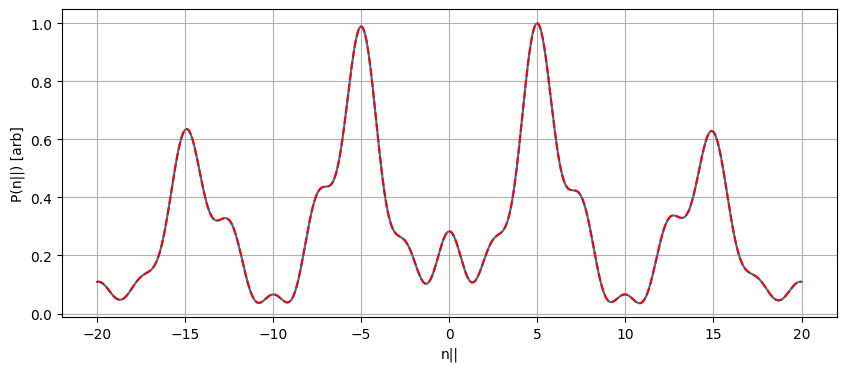

In [6]:
npar_array = np.linspace(-20, 20, 1000)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)))


# try adjusting phases by a constant 

strap_phases2 = strap_phases #+ np.array([40, 60, 20, 25, 3, 45, 180, 8, 12]) * (np.pi/180)
result2 = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases2)
    result2 = np.append(result2, power)

plt.plot(npar_array, np.real(result2)/np.max(np.real(result2)), color='red', linestyle='--')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

[  38.76533735  -57.52564163 -179.03263026   54.55775664  -74.88705166
  156.8699224    31.06947552  -92.07114936  173.17510261]
d:  0.15625
wstrap:  0.08


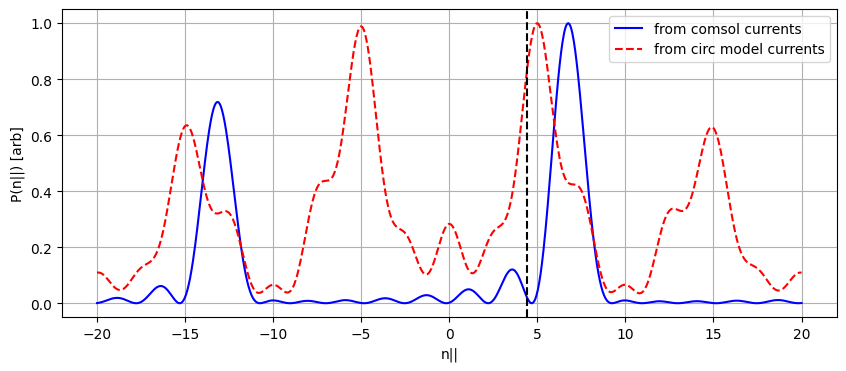

In [7]:
cap_currents = np.array([0.0031801+0.0025537*1j, 0.0029809-0.0046837*1j, -0.0056296-9.5058E-5*1j, 0.0038771+0.0054471*1j, 0.0015648-0.0057942*1j, -0.0060589+0.0025881*1j, 0.0048643+0.0029308*1j, -2.0236E-4-0.0055956*1j, -0.0040003+4.7877E-4*1j])
cap_phases = get_phase(cap_currents)
print(cap_phases*180/np.pi)
print('d: ', myrfTWA.geometry_dict['d'])
print('wstrap: ', myrfTWA.geometry_dict['wstrap'])
npar_array = np.linspace(-20, 20, 1000)

result = np.array([], dtype='complex')
freq = 96e6
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=0.085,
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=cap_phases)
    result = np.append(result, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result)/np.max(np.real(result)), color='blue', label='from comsol currents')
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='from circ model currents')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=4.384384384384383, ymin=0, ymax=1, color='k', linestyle='--')

In [8]:
# Now, test out the new optimizer 
bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (92,100)#(92, 100)
s11cutoff = -45

# new settings 
alpha = 1000 # 10,000 worked well 
target_npar = 5
npar_bounds = [0, 10]
num_npars = 100


res = myrfTWA.run_differential_evolution_global_op_npar_match( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            target_npar=5,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.0718938  0.07244658 0.06543431 0.10001204 0.06396742]
Average absolute error is : 1.76e+04
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.10736561 0.14894218 0.07138686 0.07378431 0.06645712]
Average absolute error is : 1.98e+04
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.06560511 0.09187101 0.14594793 0.06892985 0.14184895]
Average absolute error is : 1.91e+04
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.07777011 0.07006577 0.13396014 0.12985179 0.12436783]
Average absolute error is : 2.69e+04
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.05106093 0.15240582 0.14070606 0.05559601 0.11812448]
Average absolute error is : 1.84e+04
----------------------------------------
i_iter = 6
New simulation.
Point is: [0.14541824 0.12170265 0.14484154 0.06532337 0.09835406]
Avera

KeyboardInterrupt: 

In [9]:

lengths_found = res.x.tolist()
#lengths_found = [0.1289090871537399, 0.1120736062752666, 0.125719368082663, 0.08986244957445322, 0.10298948480135928]
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

NameError: name 'res' is not defined

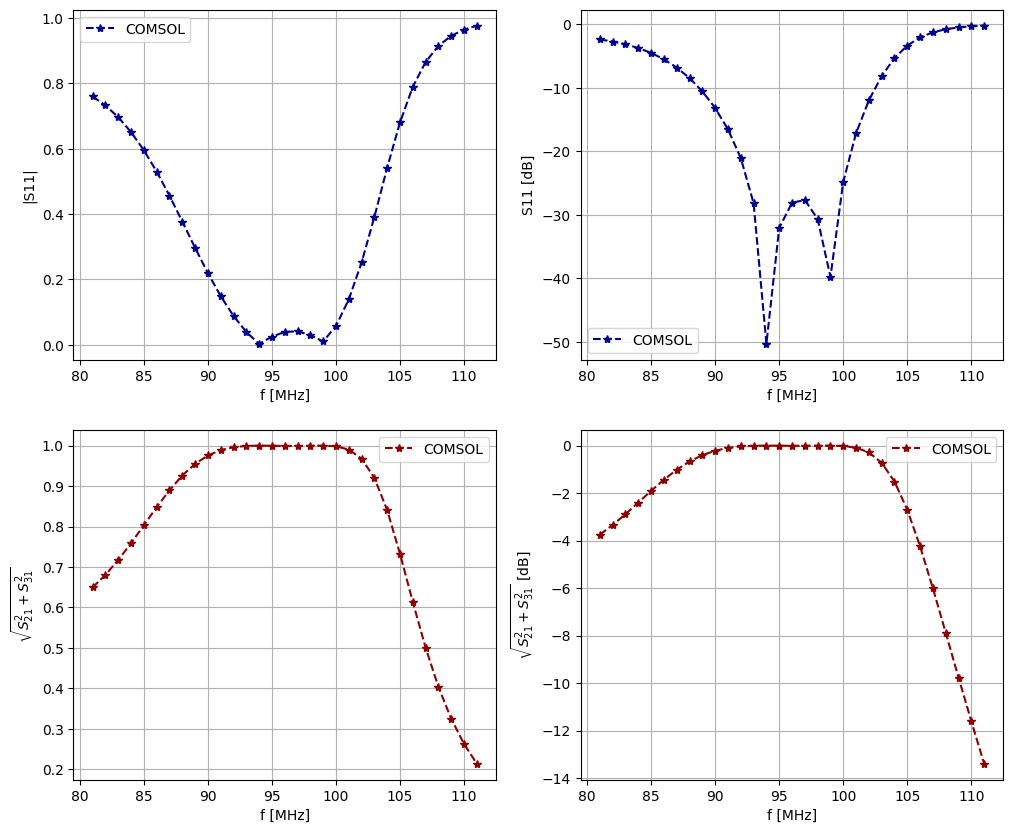

In [5]:
# compare reflections to result 
filename = 'circ_model/fscan_CF.csv'
dataset, headers = myrfTWA.get_comsol_datatable(filename)
fd = dataset[:, 0]
S11d = dataset[:,1]
S21d = dataset[:,2]
S31d = dataset[:,3]

S11d_mag = np.abs(S11d)
S21d_mag = np.abs(S21d)
S31d_mag = np.abs(S31d)

S_transd_mag = np.sqrt(S21d_mag**2 + S31d_mag**2) 

S11d_db = 20*np.log10(S11d_mag)
S_transd_db = 20*np.log10(S_transd_mag)



fig, ax = plt.subplots(2,2,figsize=(12,10))

# # plot optimization circuit
# ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue', label='circuit model')
# ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue', label='circuit model')
# ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='red', label='circuit model')
# ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='red', label='circuit model')

ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

# plot data

ax[0,0].plot(fd, S11d_mag, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[0,1].plot(fd, S11d_db, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[1,0].plot(fd, S_transd_mag, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[1,1].plot(fd, S_transd_db, marker='*', color='darkred', label='COMSOL',linestyle='--')


ax[0,0].set_xlabel('f [MHz]')
ax[0,1].set_xlabel('f [MHz]')
ax[1,0].set_xlabel('f [MHz]')
ax[1,1].set_xlabel('f [MHz]')

ax[0,0].set_ylabel('|S11|')
ax[0,1].set_ylabel('S11 [dB]')
ax[1,0].set_ylabel(r'$\sqrt{S_{21}^2 + S_{31}^2}$')
ax[1,1].set_ylabel(r'$\sqrt{S_{21}^2 + S_{31}^2}$ [dB]')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

In [11]:
#lengths_found = [0.1289090871537399, 0.1120736062752666, 0.125719368082663, 0.08986244957445322, 0.10298948480135928]
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

NameError: name 'lengths_found' is not defined

[ 0.1884757   0.69533228 -0.65506797 -0.08019937  0.21391525 -0.08857086
 -0.65149317  0.69760722  0.18875968]


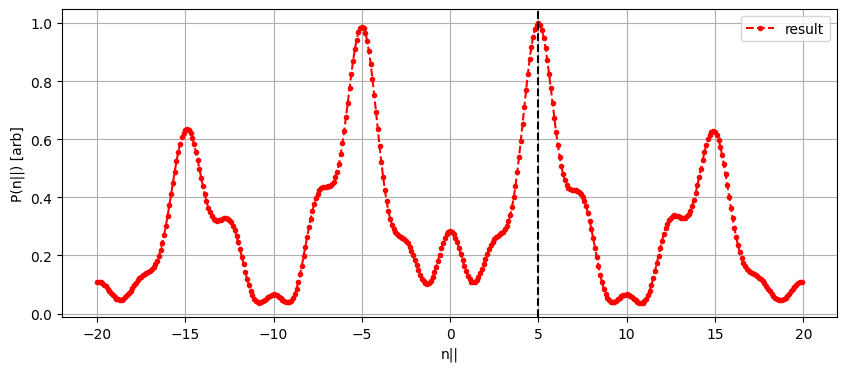

In [12]:
npar_array = np.arange(0, 10, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=5, ymin=0, ymax=1, color='k', linestyle='--')

[  36.79528046  127.78288966 -116.82108314  -16.10654897   38.73879892
  -16.13581359 -116.87639976  127.70291119   36.66689648]
d:  0.15625
wstrap:  0.08


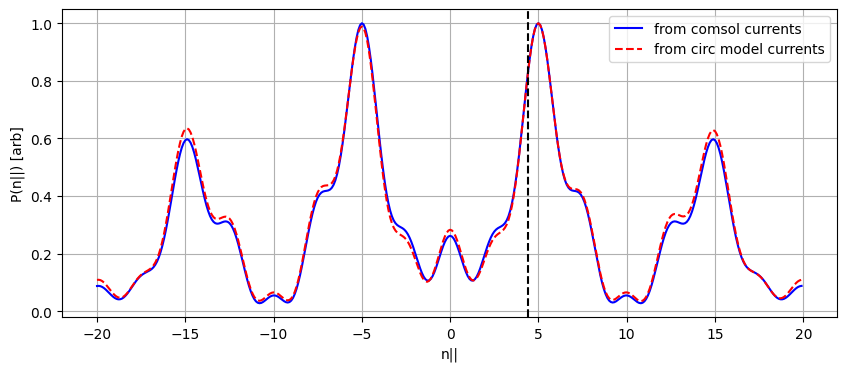

In [13]:
# compare current fourier transform 

cap_currents=[0.0022382+0.0016741*1j, -0.0023201+0.0029929*1j, -0.0014721-0.0029116*1j, 0.0025149-7.2620E-4*1j, 0.0023592+0.0018927*1j, 0.0025132-7.2710E-4*1j, -0.0014733-0.0029070*1j, -0.0023111+0.0029899*1j, 0.0022413+0.0016686*1j] 
cap_phases = get_phase(cap_currents)
print(cap_phases*180/np.pi)
print('d: ', myrfTWA.geometry_dict['d'])
print('wstrap: ', myrfTWA.geometry_dict['wstrap'])

result = np.array([], dtype='complex')
freq = 96e6
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=0.085,
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=cap_phases)
    result = np.append(result, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result)/np.max(np.real(result)), color='blue', label='from comsol currents')
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='from circ model currents')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=4.384384384384383, ymin=0, ymax=1, color='k', linestyle='--')

In [38]:
# Now, test out the new optimizerthat has n|| = 0 weighting. 
bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (92,100)#(92, 100)
s11cutoff = -45

# new settings 
alpha = 2000 # 10,000 worked well 
gamma = 1500
target_npar = 6 # TODO: change back to 5
npar_bounds = [0, 10]
num_npars = 100


res = myrfTWA.run_differential_evolution_global_op_npar_match_low_npar_zero( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            gamma_npar_op=gamma,
                                            target_npar=5,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.05723766 0.11927252 0.09688457 0.06376908 0.06361129]
Average absolute error is : 2.18e+04
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.07609116 0.10900928 0.12712399 0.14339997 0.13158142]
Average absolute error is : 1.65e+04
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.07972683 0.07262404 0.10747145 0.13191862 0.10910547]
Average absolute error is : 4.75e+04
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.07023181 0.1337101  0.14594703 0.1209339  0.11006617]
Average absolute error is : 2.99e+04
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.1418921  0.11117291 0.08083146 0.14008928 0.12512115]
Average absolute error is : 1.74e+04
----------------------------------------
i_iter = 6
New simulation.
Point is: [0.10907149 0.13156401 0.06338872 0.0940714  0.09281787]
Avera

final lengths: [0.12878498970230015, 0.08931114684940449, 0.08346384970617532, 0.11280919187444016, 0.15391258736764307]


C:\Users\jacob\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


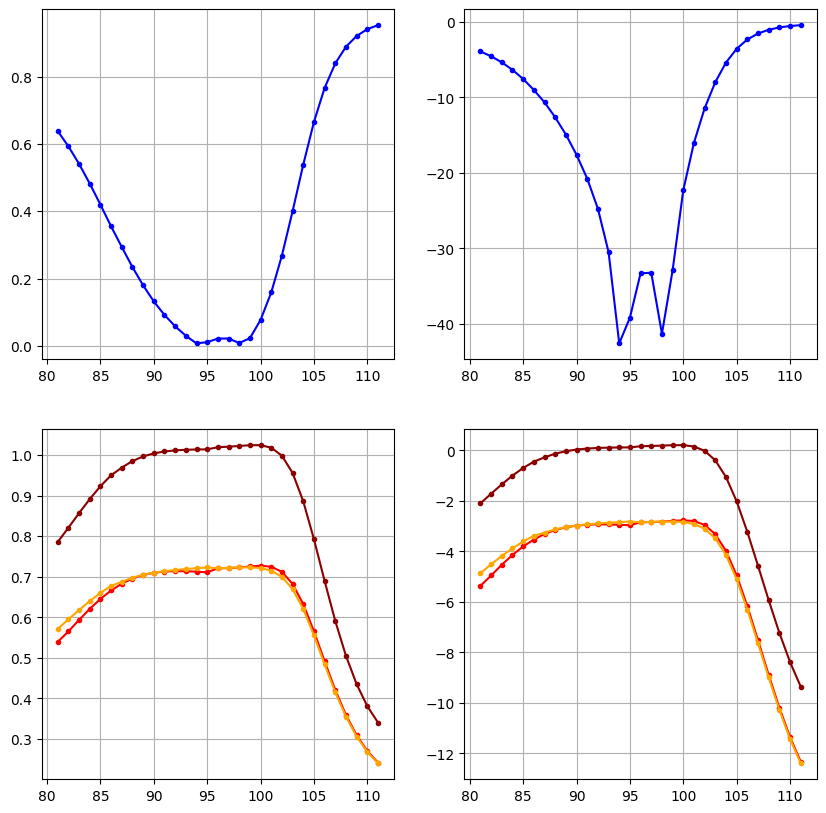

In [4]:
#lengths_found = res.x.tolist()
#lengths_found = [0.1289090871537399, 0.1120736062752666, 0.125719368082663, 0.08986244957445322, 0.10298948480135928]
# low zero, terrible reflections [0.12876049654923688, 0.09515033826794814, 0.08941864328597232, 0.08651663399900549, 0.10821744956900059]
lengths_found = [0.12878498970230015, 0.08931114684940449, 0.08346384970617532, 0.11280919187444016, 0.15391258736764307]
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

In [36]:
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

port indicies [1, 3, 5]
[ 0.17192657-0.12640074j -0.17192657+0.12640074j -0.02467195-0.14625721j
  0.02467195+0.14625721j -0.0207831 -0.1522125j   0.0207831 +0.1522125j
  0.14846882+0.10708292j -0.14846882-0.10708292j  0.01459458+0.20647433j
 -0.01459458-0.20647433j -0.06580909+0.20325447j  0.06580909-0.20325447j
 -0.16502818+0.18444423j  0.16502818-0.18444423j -0.05059558-0.2296987j
  0.05059558+0.2296987j  -0.18037961+0.19520565j  0.18037961-0.19520565j
 -0.07574663+0.21261842j  0.07574663-0.21261842j  0.00709997+0.21725588j
 -0.00709997-0.21725588j  0.15022859+0.1156674j  -0.15022859-0.1156674j ]
--
[ 0.1829823 +0.22831359j -0.22780561+0.18054005j -0.21333137-0.05952027j
  0.07633016-0.2990899j   0.37881031+0.28907925j  0.07907253-0.29823496j
 -0.20934673-0.05657857j -0.22834707+0.17727109j  0.17700452+0.22354732j]
[  51.28951149  141.60254117 -164.4106949   -75.68325368   37.34812258
  -75.15054539 -164.87640702  142.17698682   51.62785791]


[ 0.28494173  0.78668078 -0.91339275 -0.42046252  0.20748957 -0.41750303
 -0.91598004  0.78987215  0.28682143]


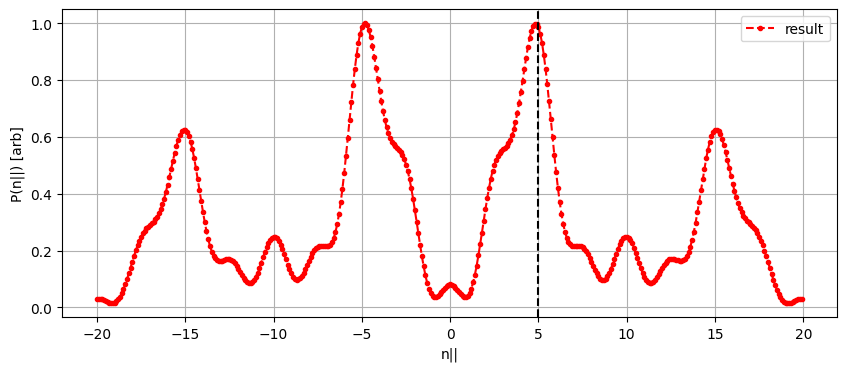

In [37]:
npar_array = np.arange(0, 10, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=5, ymin=0, ymax=1, color='k', linestyle='--')